In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [2]:
def generate_synthetic_fico_data(n=5000):
    np.random.seed(42)  # For reproducibility
    
    # Simulate Payment History
    # A mix of positive and negative factors
    payment_history = np.random.normal(700, 200, n) - np.random.choice([0, 20, 50, 100], n, p=[0.6, 0.2, 0.1, 0.1])
    
    # Simulate Amounts Owed
    # Influence of credit utilization and total balance
    amounts_owed = 850 - np.random.beta(2, 5, n) * 500  # Beta distribution for utilization skew
    
    # Simulate Length of Credit History
    # Older accounts generally mean higher scores
    length_of_credit_history = np.random.choice(range(300, 850), n, replace=True)
    
    # Simulate Credit Mix
    # More diverse credit types yield higher scores
    credit_mix = np.random.choice(range(600, 850), n, replace=True)
    
    # Simulate New Credit
    # Recent credit activities lower the score
    new_credit = 1500 - np.random.gamma(4, 100, n)
    
    # Combine into DataFrame
    data = {
        'Payment History': payment_history,
        'Amounts Owed': amounts_owed,
        'Length of Credit History': length_of_credit_history,
        'Credit Mix': credit_mix,
        'New Credit': new_credit
    }
    df = pd.DataFrame(data) # Divide by 100 to scale down the values
    
    # Calculate FICO Score with given weights
    weights = {'Payment History': 0.35, 'Amounts Owed': 0.30, 'Length of Credit History': 0.15, 'Credit Mix': 0.10, 'New Credit': 0.10}
    df['FICO Score'] = df.apply(lambda row: sum(row[feature] * weight for feature, weight in weights.items()), axis=1)
    
    return df


def w(beta, gamma):
    """
    Applies the transformation to beta.
    
    Args:
    beta (float): The input weight.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    float: The transformed weight.
    """
    return np.exp(-(-np.log(beta))**gamma)


def behavioral(weights, gamma):
    """
    Modifies the weights according to the specified formula.
    
    Args:
    weights (np.array): Original model weights.
    gamma (float): The gamma parameter for the transformation.

    Returns:
    np.array: Modified weights reflecting behavioral adjustments.
    """
    # Sort the indices of the list based on the values in descending order
    sorted_indices = sorted(range(len(weights)), key=lambda k: weights[k], reverse=True)
    
    # Create a copy of the original list to store the transformed values
    transformed = weights.copy()
    
    # Keep track of the cumulative sum of the largest elements encountered
    cumulative_sum = 0
    
    # Iterate over the indices in descending order of their corresponding values
    for i, index in enumerate(sorted_indices):
        if i == 0:
            # For the largest element, replace it with w(b_i)
            cumulative_sum = weights[index]
            transformed[index] = w(cumulative_sum, gamma)
        else:
            # For the next largest elements, replace it with w(cumulative_sum + b_i) - w(cumulative_sum)
            cumulative_sum += weights[index]
            transformed[index] = w(cumulative_sum, gamma) - w(cumulative_sum - weights[index], gamma)
    
    return transformed

In [3]:
# Generate the dataset
df = generate_synthetic_fico_data()
fico_df = df.copy()

In [4]:
# Sigmoid function to calculate probability
def sigmoid(x):
    return 1 / (1 + np.exp(-0.8 * (x/10 - 65)))

# Calculate the approval probability for each individual
fico_df['Approval Probability'] = sigmoid(fico_df['FICO Score'])

# Assign "true" labels based on approval probability being above a random threshold
# This introduces randomness in the assignment, making some borderline cases get approved or denied
fico_df['True Label'] = (fico_df['Approval Probability'] >= np.random.rand(fico_df.shape[0])).astype(int)

fico_df.head(10)

,Payment History,Amounts Owed,Length of Credit History,Credit Mix,New Credit,FICO Score,Approval Probability,True Label
0,799.342831,765.857188,769,814,880.071575,794.284304,0.999990,1
1,672.347140,786.658536,480,623,1104.109777,716.030037,0.994945,1
2,829.537708,675.942702,564,619,712.959961,710.917005,0.992410,1
3,1004.605971,687.332464,594,759,969.523657,819.764195,0.999999,1
4,653.169325,567.172030,546,831,1099.605412,673.721414,0.869632,1
5,633.172609,739.880136,723,801,1190.036494,751.128103,0.999694,1
6,995.842563,797.771687,358,779,1065.704606,826.046864,0.999999,1
7,803.486946,692.509358,757,664,1267.827734,795.706012,0.999991,1
8,606.105123,782.213437,310,822,1015.408901,677.041714,0.896909,1
9,808.512009,784.722124,646,651,1273.742533,807.770094,0.999997,1


In [5]:
def logistic_regression_with_sum_constraint(X, y):
    """
    Train logistic regression model with the constraint that coefficients sum to 1.
    Args:
    X (pd.DataFrame): Feature dataframe.
    y (pd.Series): Target vector.

    Returns:
    tuple: (coefficients, threshold)
    """
    n_samples, n_features = X.shape
    
    # Variables
    beta = cp.Variable(n_features)
    intercept = cp.Variable()

    # Logistic loss
    logits = X.values @ beta + intercept
    log_likelihood = cp.sum(
        cp.multiply(y.values, logits) - cp.logistic(logits)
    )

    # Objective and constraints
    objective = cp.Maximize(log_likelihood)
    constraints = [cp.sum(beta) == 1, 
                   beta >= 0, 
                   beta <= 1
                   ]

    # Problem
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return beta.value, intercept.value


# Optimization

In [6]:
import cvxpy as cp
import numpy as np

def classifier(x, beta, threshold):
    """
    Logistic regression classifier.
    
    Args:
    x : np.array
        Feature vector of the agent.
    beta : np.array
        Weights of the classifier.
    threshold : float
        Threshold for classification.
    
    Returns:
    int
        1 if the agent is classified as positive, 0 otherwise.
    """
    prediction = (x @ beta + threshold) > 0
    return int(prediction)

def cost_function(z, x_0):
    """
    Cost function based on norm-2 distance.
    
    Args:
    z : np.array
        Manipulated feature vector.
    x_0 : np.array
        Original feature vector.
    
    Returns:
    float
        Cost of manipulation.
    """
    return np.linalg.norm(z - x_0)


def agent_optimization(x_0, beta, threshold, mode='actual', gamma=0.5):
    """
    Solve the agent's optimization problem.
    
    Args:
    x_0 : np.array
        Original feature vector.
    beta : np.array
        Weights of the classifier.
    threshold : float
        Threshold for classification.
    R : float
        Reward for being classified as positive.
    mode : str
        Mode of optimization ('actual' or 'perceived').
    gamma : float
        Gamma parameter for behavioral.
    
    Returns:
    np.array
        Optimized feature vector if conditions are met, otherwise the original feature vector.
    """
    if mode == 'actual':
        weights = beta
    elif mode == 'perceived':
        weights = behavioral(beta, gamma)
    else:
        raise ValueError("Mode should be 'actual' or 'perceived'.")

    z = cp.Variable(len(x_0))
    cost = cp.norm(z - x_0, 2)
    eps = 1e-5
    assumed_prediction = cp.sum(cp.multiply(weights, z)) + threshold
    constraints = [assumed_prediction >= eps]
    
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    
    optimized_features = z.value

    return optimized_features

# Function to create side-by-side scatter plots with movement arrows
def create_side_by_side_plots_with_arrows(dataset1, dataset2, labels, title1, title2, beta, threshold, B, gamma, feature1, feature2, mode='NB'):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    beta_og = beta
    threshold_vis = threshold
    gamma_vis = gamma
    
    # Scatter plot for dataset1
    axs[0].scatter(dataset1[feature1], dataset1[feature2], c=labels, cmap='Spectral', alpha=0.5)
    axs[0].set_xlabel(feature1)
    axs[0].set_ylabel(feature2)
    axs[0].set_title(title1)

    # plot the line separating the two classes
    x_vals = np.array(axs[0].get_xlim())
    y_vals_nb = -(threshold_vis + beta_og[0] * x_vals) / beta_og[1]
    axs[0].plot(x_vals, y_vals_nb, color='navy', label='Non-Behavioral')
    # plot y_vals - B
    y_vals_nb = -(threshold_vis + beta_og[0] * x_vals + B) / beta_og[1]
    axs[0].plot(x_vals, y_vals_nb, '--', color='navy', label='Distance (non-behavioral)', alpha=0.5)
    
    if mode == 'B':
        # plot the line separating the two classes
        perceived_weights_vis = behavioral(beta_og, gamma=gamma_vis)
        y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals) / perceived_weights_vis[1]
        axs[0].plot(x_vals, y_vals_b, color='orangered', label='Behavioral')
        # plot y_vals - B
        y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals + B) / perceived_weights_vis[1]
        axs[0].plot(x_vals, y_vals_b, '--', color='orangered', label='Distance (behavioral)', alpha=0.5)
    
    

    # Scatter plot for dataset2
    axs[1].scatter(dataset2[feature1], dataset2[feature2], c=labels,  cmap='Spectral', alpha=0.5, marker='x')
    axs[1].set_xlabel(feature1)
    axs[1].set_ylabel(feature2)
    axs[1].set_title(title2)

    # plot the line separating the two classes
    x_vals = np.array(axs[1].get_xlim())
    y_vals_nb = -(threshold_vis + beta_og[0] * x_vals) / beta_og[1]
    axs[1].plot(x_vals, y_vals_nb, color='navy', label='Non-Behavioral')
    # plot y_vals - B
    y_vals_nb_B = -(threshold_vis + beta_og[0] * x_vals + B) / beta_og[1]
    axs[1].plot(x_vals, y_vals_nb_B, '--', color='navy', label='Distance (non-behavioral)', alpha=0.5)
    
    if mode == 'B':
        # plot the line separating the two classes
        perceived_weights_vis = behavioral(beta_og, gamma=gamma_vis)
        y_vals_b = -(threshold_vis + perceived_weights_vis[0] * x_vals) / perceived_weights_vis[1]
        axs[1].plot(x_vals, y_vals_b, color='orangered', label='Behavioral')
        # plot y_vals - B
        y_vals_b_B = -(threshold_vis + perceived_weights_vis[0] * x_vals + B) / perceived_weights_vis[1]
        axs[1].plot(x_vals, y_vals_b_B, '--', color='orangered', label='Distance (behavioral)', alpha=0.5)

    axs[0].legend()
    axs[1].legend()

    # axis with same scale
    axs[0].axis('equal')
    axs[1].axis('equal')

    # get y_max and y_min
    y_min = min(min(dataset1[feature2]), min(dataset2[feature2]))
    y_max = max(max(dataset1[feature2]), max(dataset2[feature2]))

    # get x_max and x_min
    x_min = min(min(dataset1[feature1]), min(dataset2[feature1]))
    x_max = max(max(dataset1[feature1]), max(dataset2[feature1]))

    # set axis limits
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(y_min, y_max)
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(y_min, y_max)
    
    # Draw arrows
    for i in range(len(dataset1)):
        axs[0].arrow(dataset1[feature1][i], dataset1[feature2][i],
                     dataset2[feature1][i] - dataset1[feature1][i], dataset2[feature2][i] - dataset1[feature2][i],
                     color='gray', alpha=0.9, head_width=0.02, head_length=0.02)
    # legend top right
    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Before optimization:
True positive: 3716
False positive: 285
Firm's payoff: 3431

After optimization (Non-Behavioral):
True positive: 3985
False positive: 670
Firm's payoff: 3315

After optimization (Behavioral):
True positive: 3731
False positive: 302
Firm's payoff: 3429


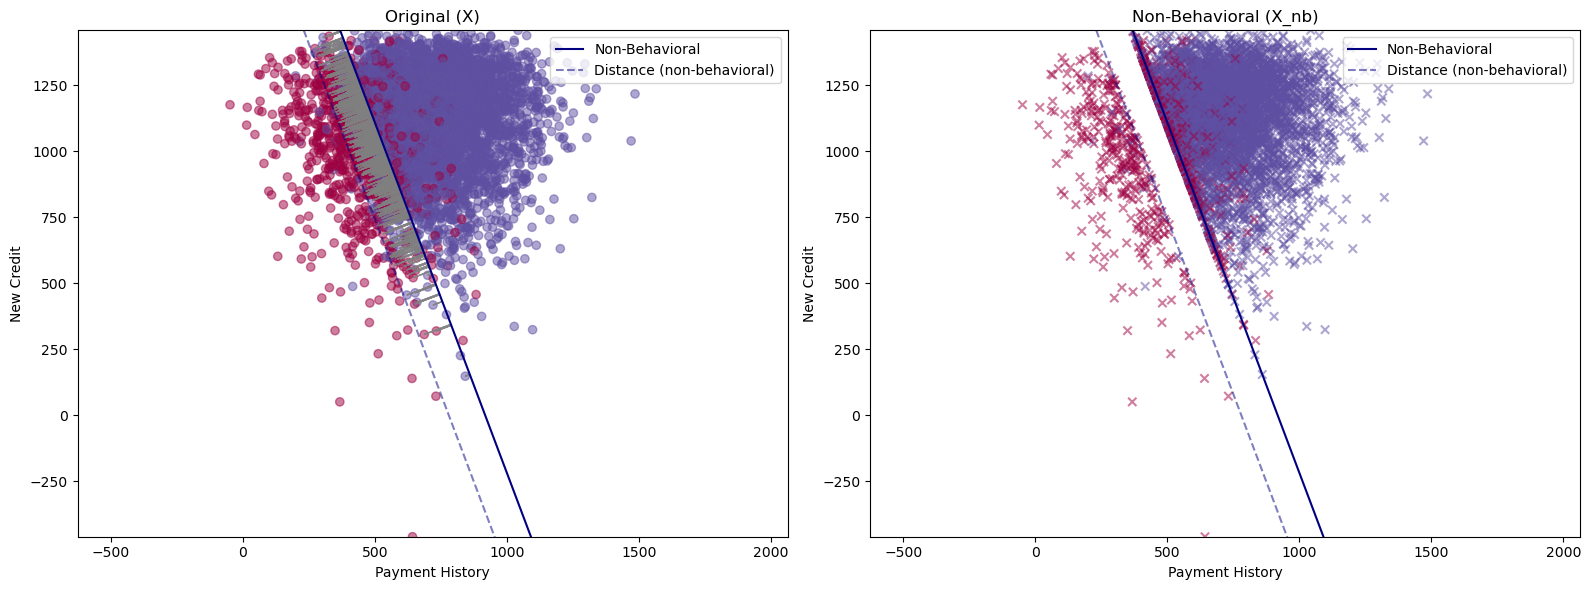

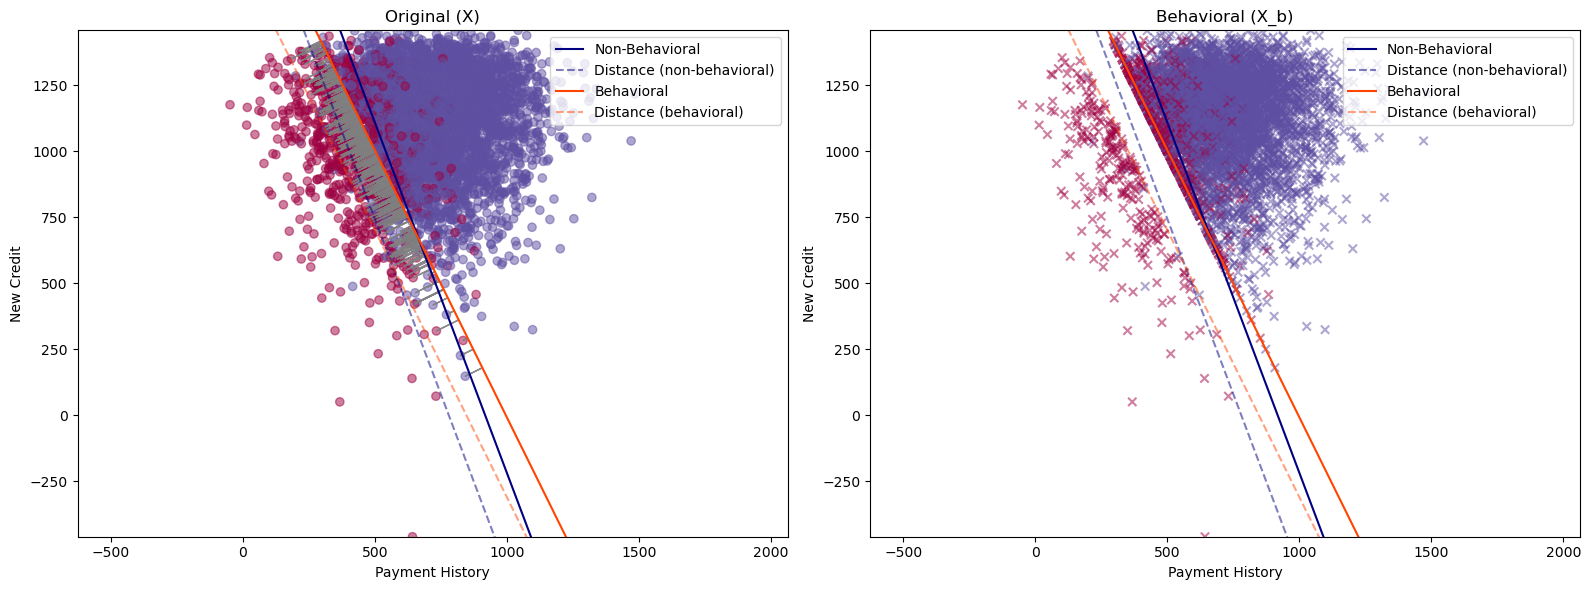

Original Beta coefficients: [0.72633358 0.27366641]
Original Threshold: -666.7944263782039

Beta coefficients (Non-Behavioral): [0.71429231 0.28570769]
Threshold (Non-Behavioral): -674.622537645266

Beta coefficients (Behavioral): [0.72838457 0.27161542]
Threshold (Behavioral): -668.947688789956


In [7]:
B = 100
gamma_vis = 0.8

feature1='Payment History'
feature2='New Credit'

X_vis = fico_df[[feature1, feature2]]
y_vis = fico_df['True Label']

beta_og, threshold_vis = logistic_regression_with_sum_constraint(X_vis, y_vis)
perceived_weights_vis = behavioral(beta_og, gamma=gamma_vis)

X_nb_vis = X_vis.copy()
X_b_vis = X_vis.copy()

# Find the agents in X that are closer than B to the decision boundary
# The ones that are closer than B to the decision boundary and classified as negative will optimize
for index_nb, row_nb in X_nb_vis.iterrows():
    if abs((row_nb @ beta_og) + threshold_vis) <= B:
        if not classifier(row_nb.values, beta_og, threshold_vis):
            X_nb_vis.loc[index_nb] = agent_optimization(row_nb.values, beta_og, threshold_vis, mode='actual')


for index_b, row_b in X_b_vis.iterrows():
    if abs((row_b @ perceived_weights_vis) + threshold_vis) <= B:
        if not classifier(row_b.values, perceived_weights_vis, threshold_vis):
            X_b_vis.loc[index_b] = agent_optimization(row_b.values, beta_og, threshold_vis, mode='perceived', gamma=gamma_vis)

# firm's payoff = True positive - False positive (printing for each case, X_nb_vis, X_b_vis, X_vis)

print("Before optimization:")
TP = 0
FP = 0
for index, row in X_vis.iterrows():
    TP += classifier(row.values, beta_og, threshold_vis) and y_vis.loc[index]
    FP += classifier(row.values, beta_og, threshold_vis) and not y_vis.loc[index]   

firm_payoff = TP - FP
print(f"True positive: {TP}")
print(f"False positive: {FP}")
print(f"Firm's payoff: {firm_payoff}")


print("\nAfter optimization (Non-Behavioral):")
TP_nb = 0
FP_nb = 0
for index, row in X_nb_vis.iterrows():
    TP_nb += classifier(row.values, beta_og, threshold_vis) and y_vis.loc[index]
    FP_nb += classifier(row.values, beta_og, threshold_vis) and not y_vis.loc[index]

firm_payoff_nb = TP_nb - FP_nb
print(f"True positive: {TP_nb}")
print(f"False positive: {FP_nb}")
print(f"Firm's payoff: {firm_payoff_nb}")

print("\nAfter optimization (Behavioral):")
TP_b = 0
FP_b = 0
for index, row in X_b_vis.iterrows():
    TP_b += classifier(row.values, beta_og, threshold_vis) and y_vis.loc[index]
    FP_b += classifier(row.values, beta_og, threshold_vis) and not y_vis.loc[index]

firm_payoff_b = TP_b - FP_b
print(f"True positive: {TP_b}")
print(f"False positive: {FP_b}")
print(f"Firm's payoff: {firm_payoff_b}")



# Create the side-by-side scatter plots with arrows
create_side_by_side_plots_with_arrows(X_vis, X_nb_vis, y_vis, 'Original (X)', 'Non-Behavioral (X_nb)', beta_og, threshold_vis, B, gamma_vis, feature1=feature1, feature2=feature2, mode='NB')
create_side_by_side_plots_with_arrows(X_vis, X_b_vis, y_vis, 'Original (X)', 'Behavioral (X_b)', beta_og, threshold_vis, B, gamma_vis, feature1=feature1, feature2=feature2, mode='B')

beta_new_b, threshold_new_b = logistic_regression_with_sum_constraint(X_nb_vis, y_vis)
beta_new_nb, threshold_new_nb = logistic_regression_with_sum_constraint(X_b_vis, y_vis)

print("Original Beta coefficients:", beta_og)
print("Original Threshold:", threshold_vis)

print("\nBeta coefficients (Non-Behavioral):", beta_new_nb)
print("Threshold (Non-Behavioral):", threshold_new_nb)

print("\nBeta coefficients (Behavioral):", beta_new_b)
print("Threshold (Behavioral):", threshold_new_b)

# Behavioral

In [196]:
def update_dataset(X, beta, threshold, B, gamma, mode='actual'):
    X_updated = X.copy()
    for index, row in X_updated.iterrows():
        if mode == 'actual':
            if abs(row @ beta + threshold) <= B:
                if not classifier(row.values, beta, threshold):
                    X_updated.loc[index] = agent_optimization(row.values, beta, threshold, mode=mode)

        elif mode == 'perceived':
            perceived_weights = behavioral(beta, gamma=gamma)
            if abs(row @ perceived_weights + threshold) <= B:
                if not classifier(row.values, perceived_weights, threshold):
                    X_updated.loc[index] = agent_optimization(row.values, beta, threshold, mode=mode, gamma=gamma)

    return X_updated

iterations = 100
B = 100
gamma = 0.8

X_0 = fico_df[['Payment History', 'New Credit']]
y_0 = fico_df['True Label']
beta_og_0, threshold_vis_0 = logistic_regression_with_sum_constraint(X_0, y_0)    
print(f"Initial Beta coefficients: {beta_og_0}, Initial Threshold: {threshold_vis_0}")

X_b_updates = X_0.copy()
beta_og = beta_og_0
threshold_vis = threshold_vis_0

for i in range(iterations):
    X_b_updates_new = update_dataset(X_b_updates, beta_og, threshold_vis, B, gamma, mode='perceived')
    # calculate false positives and true positives for the updated dataset
    beta_new, threshold_new = logistic_regression_with_sum_constraint(X_b_updates_new, y_0)
    print(f"Iteration {i+1}: Beta coefficients: {beta_new}, Threshold: {threshold_new}")
    
    X_b_updates = X_b_updates_new

    if np.linalg.norm(beta_new - beta_og) < 1e-6:
        beta_og = beta_new
        break

    beta_og = beta_new

threshold_vis = threshold_new

print(f"Converged after {i+1} iterations.")
print("Beta coefficients:", beta_og)
print("Threshold:", threshold_vis)

/Users/macbook/opt/anaconda3/lib/python3.9/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Initial Beta coefficients: [0.72469569 0.2753043 ], Initial Threshold: -666.6296244811524
Iteration 1: Beta coefficients: [0.7111678 0.2888322], Threshold: -675.3664184687094
Iteration 2: Beta coefficients: [0.70972329 0.2902767 ], Threshold: -676.2960913881728
Iteration 3: Beta coefficients: [0.70957579 0.29042421], Threshold: -676.3909866585524
Iteration 4: Beta coefficients: [0.70956082 0.29043918], Threshold: -676.4006252931417
Iteration 5: Beta coefficients: [0.70955928 0.29044072], Threshold: -676.4016159372328
Iteration 6: Beta coefficients: [0.70955912 0.29044087], Threshold: -676.4017166597457
Converged after 6 iterations.
Beta coefficients: [0.70955912 0.29044087]
Threshold: -676.4017166597457


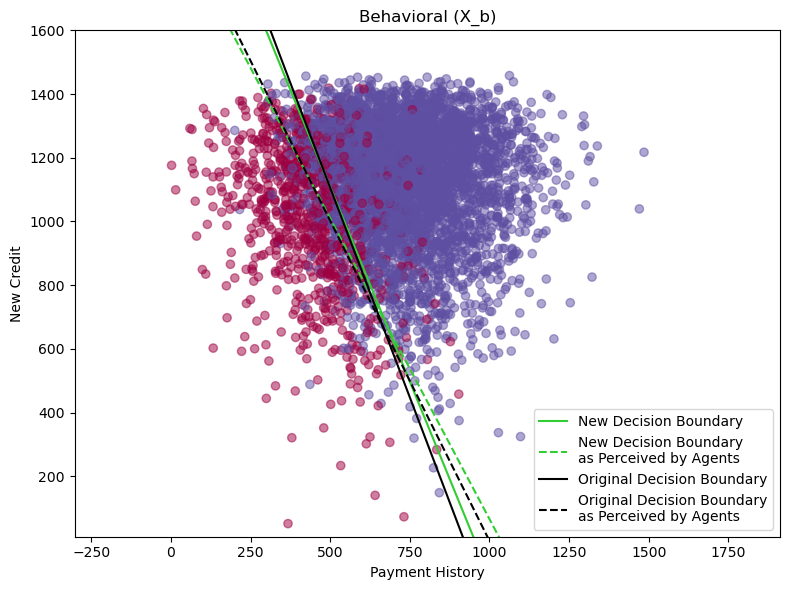

In [197]:
# plot with create_side_by_side_plots_with_arrows(dataset1, dataset2, labels, title1, title2, feature1=feature1, feature2=feature2, mode='NB')
# create_side_by_side_plots_with_arrows(X_0, X_b_updates_new, y_0, 'Original (X)', 'Behavioral (X_b)', beta_og_0, threshold_vis_0, B, gamma, mode='B')

beta_og_0, threshold_vis_0 = logistic_regression_with_sum_constraint(X_0, y_0)
perceived_weights_vis_0 = behavioral(beta_og_0, gamma=gamma)
perceived_weights_vis_b = behavioral(beta_og, gamma=gamma)

# plot the line separating the new decision boundary on X_b_updates
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_0[feature1], X_0[feature2], c=y_0, cmap='Spectral', alpha=0.5)
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_title('Behavioral (X_b)')

# axis with same scale
ax.axis('equal')

ax.set_ylim(10, 1600)
ax.set_xlim(10, 1600)

x_vals = np.array(ax.get_xlim())
y_vals_b = -(threshold_vis + beta_og[0] * x_vals) / beta_og[1]
y_vals_og = -(threshold_vis_0 + beta_og_0[0] * x_vals) / beta_og_0[1]
y_vals_b_perc = -(threshold_vis + perceived_weights_vis_b[0] * x_vals) / perceived_weights_vis_b[1]
y_vals_og_perc = -(threshold_vis_0 + perceived_weights_vis_0[0] * x_vals) / perceived_weights_vis_0[1]
ax.plot(x_vals, y_vals_b, color='limegreen', label='New Decision Boundary')
ax.plot(x_vals, y_vals_b_perc, '--', color='limegreen', label='New Decision Boundary\nas Perceived by Agents')
ax.plot(x_vals, y_vals_og, color='k', label='Original Decision Boundary')
ax.plot(x_vals, y_vals_og_perc, '--', color='k', label='Original Decision Boundary\nas Perceived by Agents')
ax.legend()
plt.tight_layout()
plt.show()



Scenario 1 - Original Decision Boundary:
True positive: 3784
False positive: 293
True negative: 657
False negative: 266
True predictions: 4441
False Prediction: 559
Firm's payoff: 3491

Scenario 2 - New Decision Boundary:
True positive: 3782
False positive: 295
True negative: 655
False negative: 268
True predictions: 4437
False Prediction: 563
Firm's payoff: 3487

Scenario 1 - Original Decision Boundary: Firm uses the original decision boundary and individuals optimize based on the perceived weights.


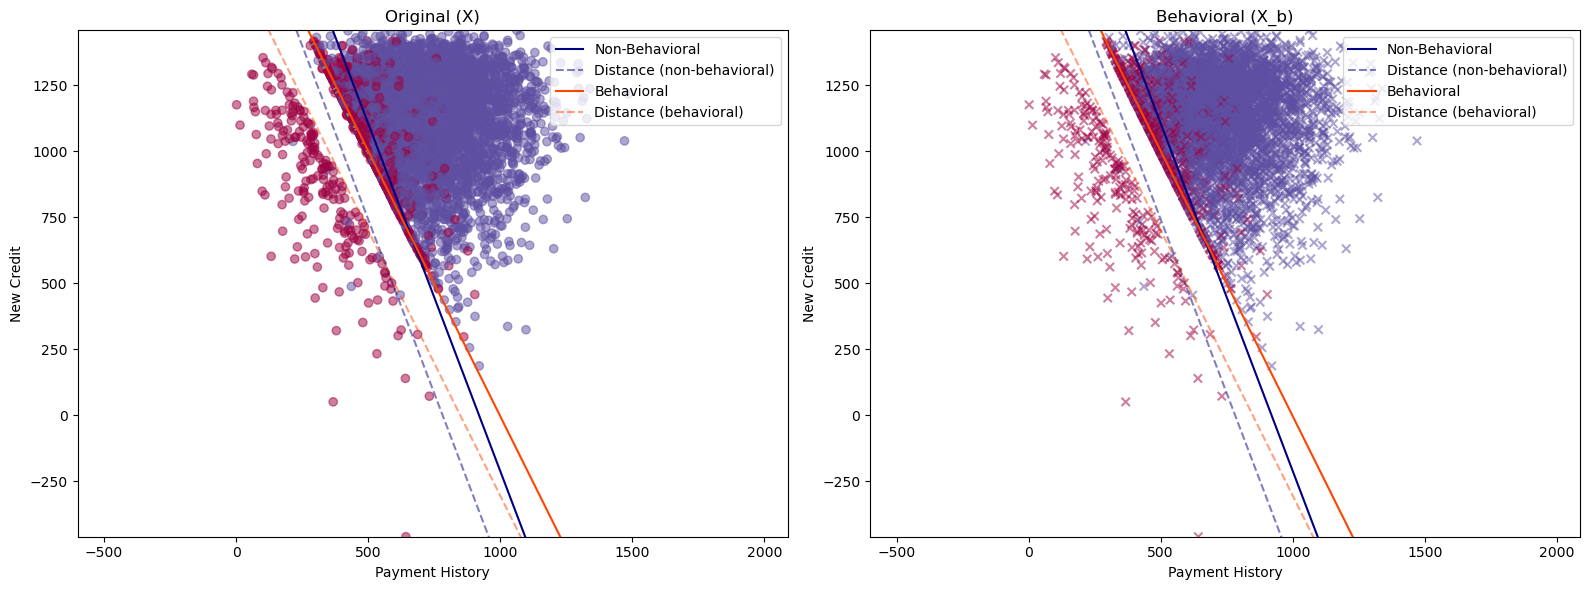

Scenario 2 - New Decision Boundary: Firm uses the optimal decision boundary and individuals optimize based on the perceived weights.


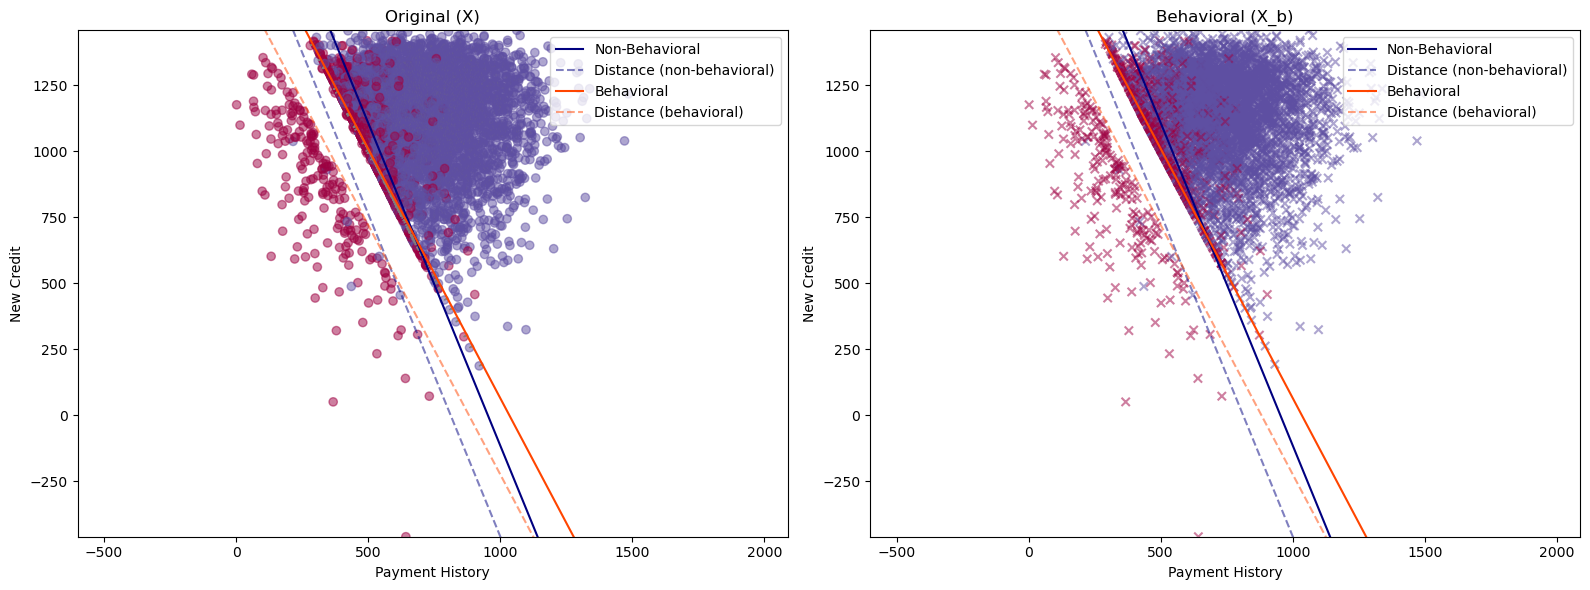

In [198]:
# If the firm announced the original DB:
X_scenario_1 = X_b_updates.copy()
for index_b, row_b in X_scenario_1.iterrows():
    if abs((row_b @ perceived_weights_vis_0) + threshold_vis_0) <= B:
        if not classifier(row_b.values, perceived_weights_vis_0, threshold_vis_0):
            X_scenario_1.loc[index_b] = agent_optimization(row_b.values, beta_og_0, threshold_vis_0, mode='perceived', gamma=gamma)

# If the firm announced the new DB:
X_scenario_2 = X_b_updates.copy()
for index_b, row_b in X_scenario_2.iterrows():
    if abs((row_b @ perceived_weights_vis_b) + threshold_vis) <= B:
        if not classifier(row_b.values, perceived_weights_vis_b, threshold_vis):
            X_scenario_2.loc[index_b] = agent_optimization(row_b.values, beta_og, threshold_vis, mode='perceived', gamma=gamma)

TP_b_s1 = 0
FP_b_s1 = 0
TN_b_s1 = 0
FN_b_s1 = 0

TP_b_s2 = 0
FP_b_s2 = 0
TN_b_s2 = 0
FN_b_s2 = 0

for index, row in X_scenario_1.iterrows():
    TP_b_s1 += classifier(row.values, beta_og_0, threshold_vis_0) and y_0.loc[index]
    FP_b_s1 += classifier(row.values, beta_og_0, threshold_vis_0) and not y_0.loc[index]
    TN_b_s1 += not classifier(row.values, beta_og_0, threshold_vis_0) and not y_0.loc[index]
    FN_b_s1 += not classifier(row.values, beta_og_0, threshold_vis_0) and y_0.loc[index]

for index, row in X_scenario_2.iterrows():
    TP_b_s2 += classifier(row.values, beta_og, threshold_vis) and y_0.loc[index]
    FP_b_s2 += classifier(row.values, beta_og, threshold_vis) and not y_0.loc[index]
    TN_b_s2 += not classifier(row.values, beta_og, threshold_vis) and not y_0.loc[index]
    FN_b_s2 += not classifier(row.values, beta_og, threshold_vis) and y_0.loc[index]

firm_payoff_b_s1 = TP_b_s1 - FP_b_s1
firm_payoff_b_s2 = TP_b_s2 - FP_b_s2

print("\nScenario 1 - Original Decision Boundary:")
print(f"True positive: {TP_b_s1}")
print(f"False positive: {FP_b_s1}")
print(f"True negative: {TN_b_s1}")
print(f"False negative: {FN_b_s1}")
print(f"True predictions: {TN_b_s1+TP_b_s1}")
print(f"False Prediction: {FP_b_s1+FN_b_s1}")
print(f"Firm's payoff: {firm_payoff_b_s1}")

print("\nScenario 2 - New Decision Boundary:")
print(f"True positive: {TP_b_s2}")
print(f"False positive: {FP_b_s2}")
print(f"True negative: {TN_b_s2}")
print(f"False negative: {FN_b_s2}")
print(f"True predictions: {TN_b_s2+TP_b_s2}")
print(f"False Prediction: {FP_b_s2+FN_b_s2}")
print(f"Firm's payoff: {firm_payoff_b_s2}")

print("\nScenario 1 - Original Decision Boundary: Firm uses the original decision boundary and individuals optimize based on the perceived weights.")
create_side_by_side_plots_with_arrows(X_b_updates, X_scenario_1, y_0, 'Original (X)', 'Behavioral (X_b)', beta_og_0, threshold_vis_0, B, gamma, feature1=feature1, feature2=feature2, mode='B')
print("Scenario 2 - New Decision Boundary: Firm uses the optimal decision boundary and individuals optimize based on the perceived weights.")
create_side_by_side_plots_with_arrows(X_b_updates, X_scenario_2, y_0, 'Original (X)', 'Behavioral (X_b)', beta_og, threshold_vis, B, gamma, feature1=feature1, feature2=feature2, mode='B')

# Non Behavioral

In [23]:
iterations = 100
B = 100
gamma = 0.3

X_0 = fico_df[['Payment History', 'New Credit']]
y_0 = fico_df['True Label']
beta_og, threshold_vis = logistic_regression_with_sum_constraint(X_0, y_0)    

for i in range(iterations):
    X_b_updates = X.copy()

    X_b_updates = update_dataset(X_0, beta_og, threshold_vis, B, gamma, mode='actual')
    beta_new, threshold_new = logistic_regression_with_sum_constraint(X_b_updates, y_0)
    print(f"Iteration {i+1}: Beta coefficients: {beta_new}, Threshold: {threshold_new}")

    if np.linalg.norm(beta_new - beta_og) < 1e-5:
        break

    beta_og = beta_new

print(f"Converged after {i+1} iterations.")
print("Beta coefficients:", beta_og)
print("Threshold:", threshold_vis)

Iteration 1: Beta coefficients: [0.80732772 0.19267227], Threshold: -650.0081075267743
Iteration 2: Beta coefficients: [0.809946   0.19005399], Threshold: -650.0150204409775
Iteration 3: Beta coefficients: [0.81214785 0.18785214], Threshold: -649.9904154703446
Iteration 4: Beta coefficients: [0.81406122 0.18593878], Threshold: -649.9610735777377
Iteration 5: Beta coefficients: [0.8157421  0.18425789], Threshold: -649.9460255104757
Iteration 6: Beta coefficients: [0.81710876 0.18289123], Threshold: -649.9877208733769
Iteration 7: Beta coefficients: [0.81814349 0.1818565 ], Threshold: -650.0567954293683
Iteration 8: Beta coefficients: [0.81894703 0.18105296], Threshold: -650.1057412035798
Iteration 9: Beta coefficients: [0.81956849 0.1804315 ], Threshold: -650.1453784480871
Iteration 10: Beta coefficients: [0.82004773 0.17995226], Threshold: -650.1765662188589
Iteration 11: Beta coefficients: [0.82041765 0.17958234], Threshold: -650.2001101242352
Iteration 12: Beta coefficients: [0.82063

In [24]:
print("Before optimization:")
TP_0 = 0
FP_0 = 0
for index, row in X_0.iterrows():
    TP_0 += classifier(row.values, beta_og, threshold_vis) and y_0.loc[index]
    FP_0 += classifier(row.values, beta_og, threshold_vis) and not y_0.loc[index]   

firm_payoff_0 = TP_0 - FP_0
print(f"True positive: {TP_0}")
print(f"False positive: {FP_0}")
print(f"Firm's payoff: {firm_payoff_0}")


print("\nAfter optimization (Non-Behavioral):")
TP_b = 0
FP_b = 0
for index, row in X_b_updates.iterrows():
    TP_b += classifier(row.values, beta_og, threshold_vis) and y_0.loc[index]
    FP_b += classifier(row.values, beta_og, threshold_vis) and not y_0.loc[index]

firm_payoff_b = TP_b - FP_b
print(f"True positive: {TP_b}")
print(f"False positive: {FP_b}")
print(f"Firm's payoff: {firm_payoff_b}")

Before optimization:
True positive: 721
False positive: 43
Firm's payoff: 678

After optimization (Non-Behavioral):
True positive: 774
False positive: 133
Firm's payoff: 641


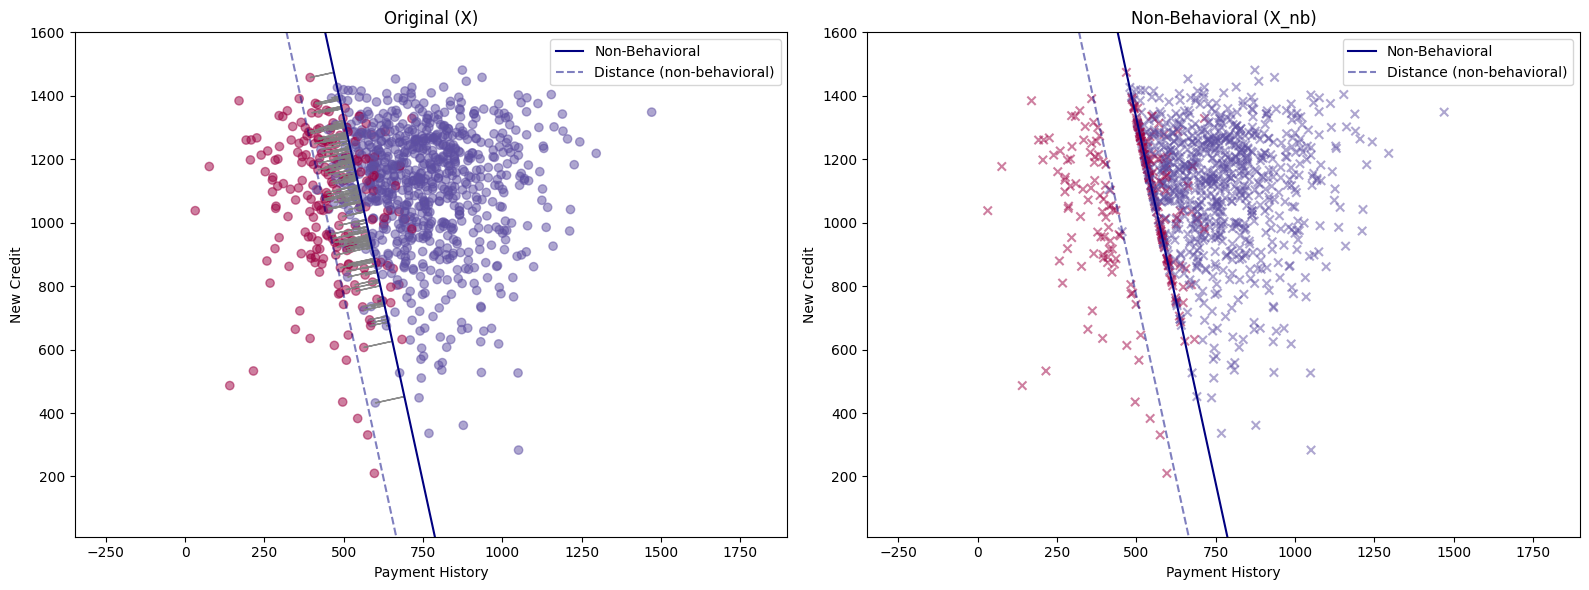

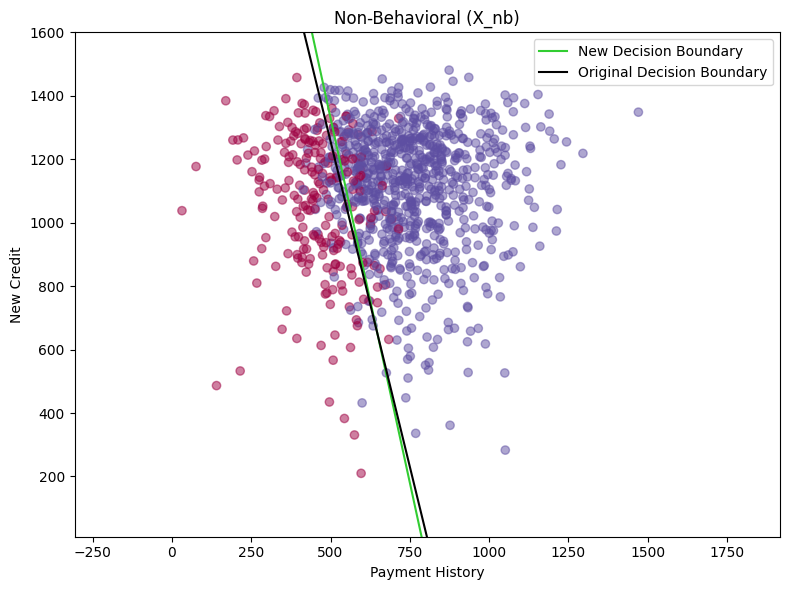

In [25]:
# plot with create_side_by_side_plots_with_arrows(dataset1, dataset2, labels, title1, title2, feature1=feature1, feature2=feature2, mode='NB')
create_side_by_side_plots_with_arrows(X_0, X_b_updates, y_0, 'Original (X)', 'Non-Behavioral (X_nb)', beta_og, threshold_vis_0, B, gamma, mode='NB')


# plot the line separating the new decision boundary on X_b_updates
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_0[feature1], X_0[feature2], c=y_0, cmap='Spectral', alpha=0.5)
ax.set_xlabel(feature1)
ax.set_ylabel(feature2)
ax.set_title('Non-Behavioral (X_nb)')

# axis with same scale
ax.axis('equal')

ax.set_ylim(10, 1600)
ax.set_xlim(10, 1600)

x_vals = np.array(ax.get_xlim())
y_vals_nb = -(threshold_vis + beta_og[0] * x_vals) / beta_og[1]
y_vals_og = -(threshold_vis + beta_og_0[0] * x_vals) / beta_og_0[1]
ax.plot(x_vals, y_vals_nb, color='limegreen', label='New Decision Boundary')
ax.plot(x_vals, y_vals_og, color='k', label='Original Decision Boundary')
ax.legend()
plt.tight_layout()
plt.show()
